# CS146 Project 2: Discrete and multi-level models

Here is a data set of kelp plant counts near the coast. The coastal area was divided into 100 20 m × 20 m grid squares and the number of kelp was painstakingly counted in each grid square. Unfortunately, some of the grid squares were not counted.

Your task is to fit an appropriate discrete count model for this data set and to estimate the number of kelp in the missing cells.

Prior knowledge: We expect something like 0 to 2 kelp plants per square meter. Note: Each grid square has an area of 400 m².

In [41]:
## The next two cells are important to optimize certain sections of the code. Please restart runtime/kernel after installing and updating these bibraries. 

In [42]:
!pip install numpy==1.23.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import pymc.sampling.jax as pmjax

In [45]:
import jax
jax.default_backend()

#If the default backend is gpu, then a certain function would work as intended. 

'cpu'

## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

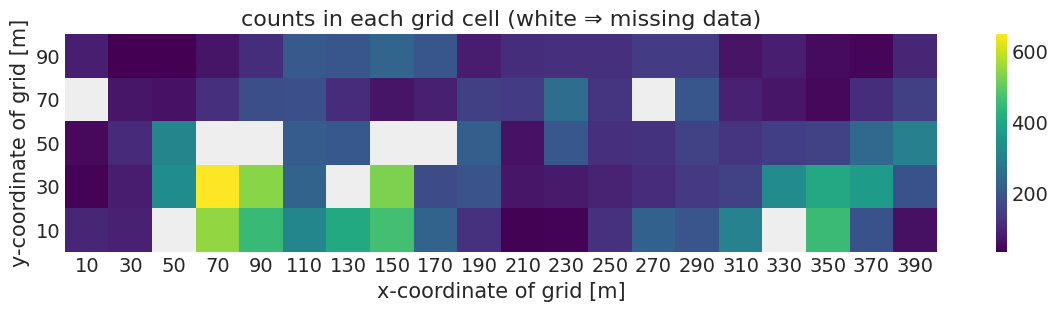

In [91]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import nan
import pymc as pm

plt.rcParams.update({'font.size': 12})
az.style.use("arviz-darkgrid")
grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([[101,  92, np.nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, np.nan, 454, 191,  63],
                [ 43,  86, 334, 649, 540, 231, np.nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
                [ 51, 110, 314, np.nan, np.nan, 215, 205, np.nan, np.nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
                [np.nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, np.nan, 199,  92,  74,  49, 116, 153],
                [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.grid(False)
plt.show()

# Table of Content

1.   Complete Pooling
2.   Partial Pooling
3.   Reparametrized model for Partial Pooling

## Optional Question

1. Testing the Spatial Poisson Model on a subset
2. Applying the model on a large dataset
  1. With Automatic Deterministic Imputation
  2. Without Automatic Imputation


### Note on LOs and HCs Used







## Complete Pooling
We are choosing this method to begin the process of predicting the missing kelp count data. This is making an assumption that all of the kelp counts come from the same source and have the same causal factors influencing their distribution.

We begin the process of discovery by understanding the distribution of kelp counts in our sample. This is done to ensure that our prior can atleast mimic what our observed values look like. 

Note that we are not calculating the mean, mode or median of the obeservations to ensure that Fundamental Bayesian priciples are followed and our choice of prior does not get biased. 

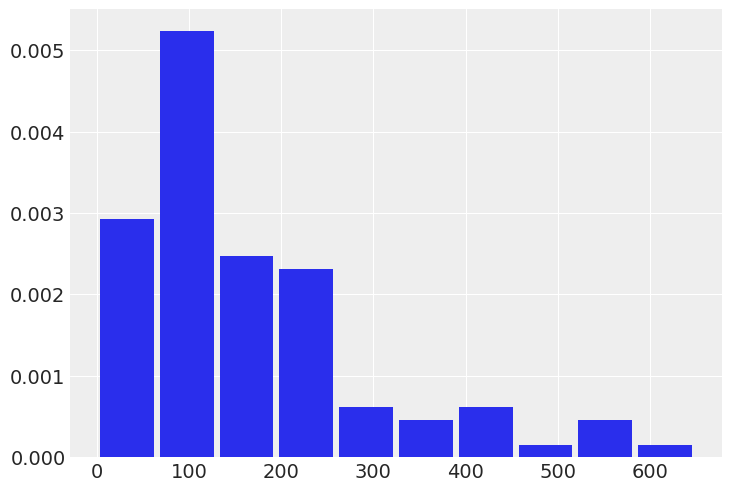

In [52]:
#Removing nan values to 0.
data1 = np.nan_to_num(data)
plt.hist(data1.flatten(), density = True, rwidth=0.9)
plt.show()

### Data Distribution

We can see above that data is mostly cooncentrated near 0-200. This would mean that there are not a lot of units that have values more than this range. We would need to choose something that has more weight on the left side of the average number of kelp that we expect to find. 

As mentioned in the problem statement above, we intent to find kelp that is in the range of 0 to 2 per sq. meter. Given there are 400 sq. mtrs, our mean number of kelp would be 400. 

The data itself however, does not put of a lot density on 400. 

## Modeling Justification

This distribution has been mapped on a Poisson distribution. But, the parameters for it come from a normal distribution. This is done because the client has not provided any information about kelp counts. All we know is, the expected range of kelp we are supposed to find. We can use the average of this range as the mean for our prior. 

The paramters for this distribution are chosen on the basis of plotting various normal distribution with different params. 

We are using a log link function to map this on a Poisson distribution. This has been done because normal distribution in continous in nature and the values in the dataset do not have decimals. Furthermore, the problem statement clearly states that this is what needs to be done. 

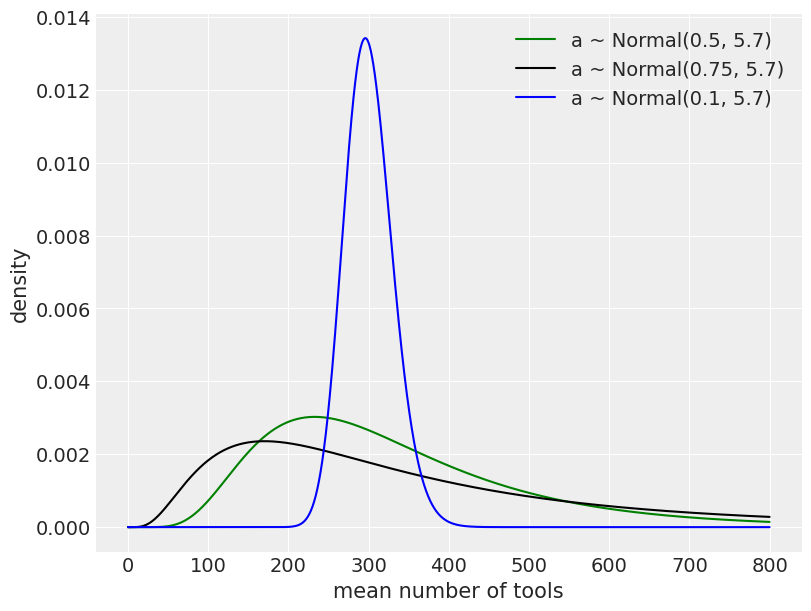

In [53]:
from scipy import stats as sts
x = np.linspace(0, 800, 1600)
plt.figure(figsize=(8, 6))
plt.plot(x, sts.lognorm(0.5, scale=np.exp(5.7)).pdf(x), color='green', label='a ~ Normal(0.5, 5.7)')
plt.plot(x, sts.lognorm(0.75, scale=np.exp(5.7)).pdf(x), color='k', label='a ~ Normal(0.75, 5.7)')
plt.plot(x, sts.lognorm(0.1, scale=np.exp(5.7)).pdf(x), color='b', label='a ~ Normal(0.1, 5.7)')
plt.xlabel('mean number of tools')
plt.ylabel('density')
plt.legend()
plt.show()

### Prior Selection

The three plots above show how changing the value of sigma alone could shift where majority of the plot density of a normal distribution lies. Ideally, we should choose a distribution that is centered around the mean (log(400) -> 5.99). But, by being this impartial, we would end up making a trade off, and not incorporate what we have seen in the data. 

Therefore, to balance everything out, we would choose 5.7 as the mean, and 0.75 as the standard deviation. This would ensure that our prior distribution is optimized. 

/usr/local/lib/python3.9/dist-packages/pymc/model.py:1402: ImputationWarning: Data in kelp_count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


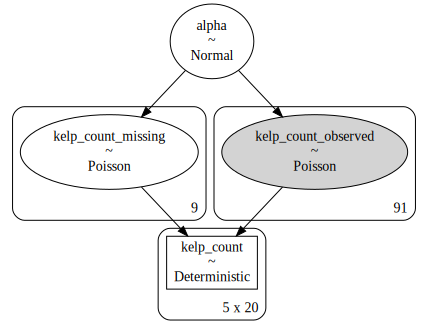

In [ ]:
##Complete Pooling
with pm.Model() as model1:
    #Define model
    alpha = pm.Normal('alpha', mu=5.75, sigma=0.75) 
    lambda_ = pm.math.exp(alpha)
    kelp_count = pm.Poisson('kelp_count', mu=lambda_, shape = (5,20), observed=data)
    # sample prior predictive
    prior_pred = pm.sample_prior_predictive(1000)
pm.model_to_graphviz(model1)

In [ ]:
alpha_prior = prior_pred.prior.alpha.values
lam_pri = np.exp(alpha_prior)

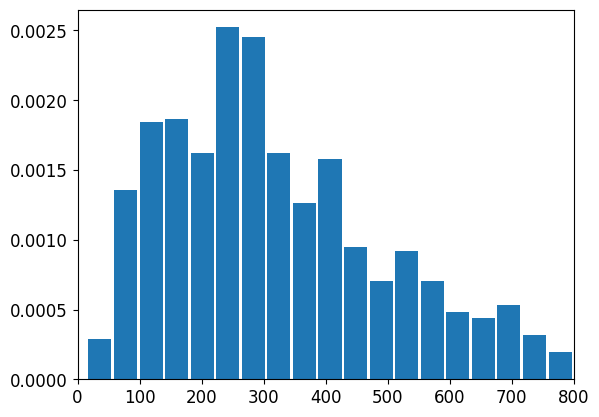

In [ ]:
hist_lam = lam_pri[0]
plt.hist(hist_lam, density=True, bins=100, rwidth=0.9)
plt.xlim((0,800))
plt.show()

With prior predictive, we can easily see that our prior is fairly biased towards the range of 150-400 kelp count and does not give 

This prior has not been juxtaposed with the actual data yet, the graph is available below.  

In [ ]:
with model1:
    inference = pm.sample(5000, tune = 2500, target_accept=0.9, chains = 4)
    posterior_predictive = pm.sample_posterior_predictive(inference)

(0.0, 800.0)

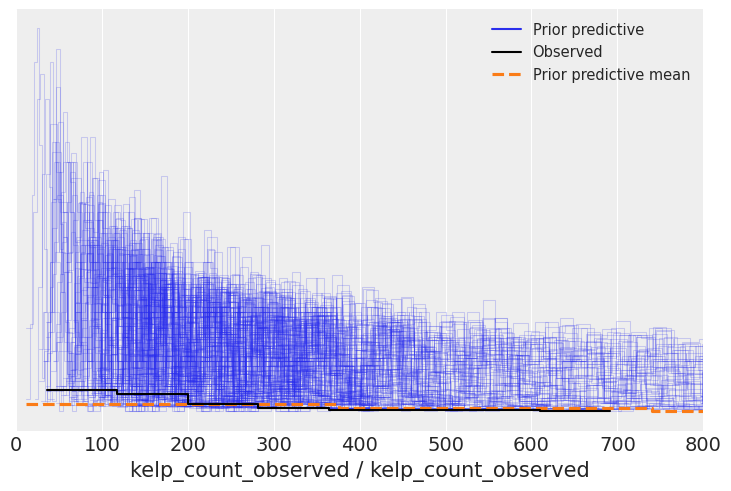

In [ ]:
az.plot_ppc(prior_pred, group='prior')
plt.xlim((0,800))

The prior predictive distribution shows us that this prior is not taking the data into account at all. The density of most predictive samples which are below 100 much high than how much our distribution is weighing it. 

This means, despite having a standard deviation which is greater than 1, our prior failed to account for high values.  

<Axes: xlabel='kelp_count_observed / kelp_count_observed'>

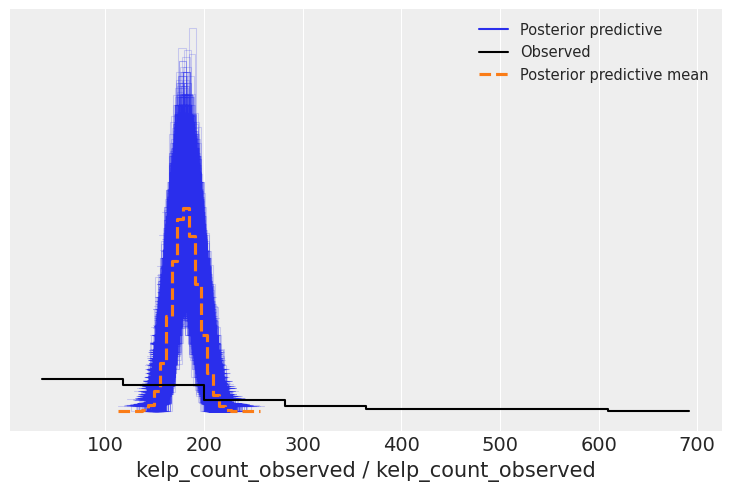

In [ ]:
az.plot_ppc(posterior_predictive)

The posterior predictive shows us how off the calculations from our likelihood function is. One could call this model good enough, if we knew that the values of the missing cells were from the range on 100-200 (0-0.5/sq mtr), however, the client has clearly mentioned that they expect to find more kelp counts. 

In [ ]:
## Printing out the kelp count variable in order to understand how to extract the value of mean kelp count
## Of a particular cell.

#We will use this navigate the coordinates of all the kelp counts. By using to mean(axis=0), we are ensuring that sampling of multiple chains does not impact us in any way. 

#Uncomment the line below to see the data structure. 

#print(posterior_predictive.posterior_predictive)

postp_mean1 = posterior_predictive.posterior_predictive.kelp_count.mean(axis=0).mean(axis=0)

In [54]:
empty_cords = []

for i in range(len(data)):
  for j in range(len(data[i])):
    if np.isnan(data[i,j]):
      empty_cords.append([i,j])

In [ ]:
data_pos = data.copy

for i in empty_cords:
  data_pos[i[0], i[1]] = postp_mean1[i[0], i[1]]

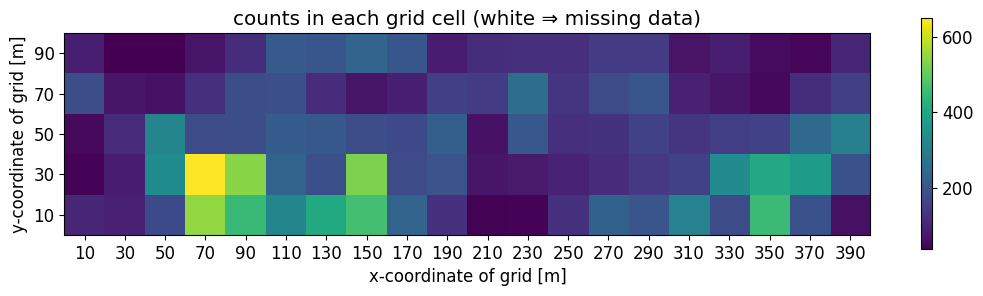

In [ ]:
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_pos, origin='lower')
plt.xticks(np.arange(data_pos.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_pos.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

The posterior predictive is based on the information that has been accounted for. This is helpful in order to understand how our posterior fits with the observed values. 

We can see that cells that were missing stand out. This is problematic because kelps are organisms whose distribution would be localized. This is important information, and our posterior is not taking this into account. 

### Diagnostics

We can see below that the r hat value is at 1. This indicates that the chains are converging to the optimum value in the posterior. The ess values are also above 1000s, which means our sampler did not face the issue of autocorrelation between the chains. This indicates that all the chains worked independently. The chains are evenly sampled in the rank plot. This is another indicator of them converging at the right value.



mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  5.195  0.008   5.181    5.209        0.0      0.0    7135.0   10768.0   

       r_hat  
alpha    1.0

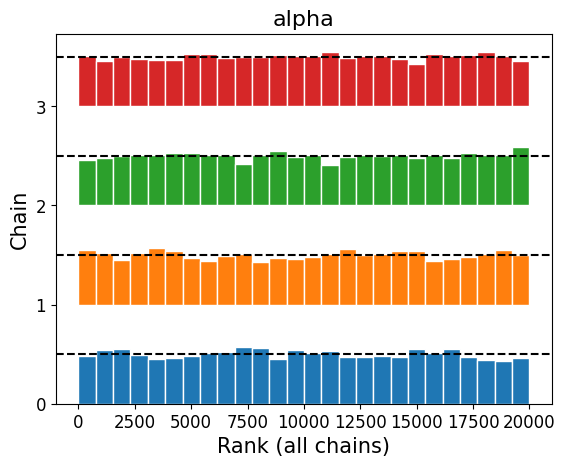

In [ ]:
import arviz as az
az.plot_rank(inference, var_names=['alpha'])
az.summary(inference, var_names=['alpha'])

In order to perform partial pooling, we would need to get a different alpha paramter for every cell. However, the parameters that make up the distribution of alphas would be derived from an identical distribution. 

In [ ]:
x = np.linspace(0, 800, 1600)

In [ ]:
data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])
#Defining the co-ordinates and indices which will work through the numpy array
x_vals = np.array([np.arange(0, 20) for i in range(0,5)]).flatten()
y_vals = np.array([np.arange(0, 5) for i in range(0,20)]).flatten()

## Partial Pooling
In the next model, we would make the assumption that the main alpha parameter comes from a normal distribution which would become the rate paramter for our main poisson model. However, this alpha would vary for each cell since we would make it sample differently for all of them. 

Nonetheless, we are assuming that the paramters for the alpha distribution come from the same distribution. For the means, we have chosen a normal distribution with 5.99 (log(400)) as the mean, and the sigma as 0.5. In the previous model, we had intentionally decided to lower the value of the mean, but we don't need to do that here since every cell would be sampled differently. Going by the same line of thinking, we have also chosen a lower sigma value. 

The distriibution of standard deviations comes from a half-normal distribution with 0.75 as the parameter. We could not choose a distribution that has negative values.

In [ ]:
with pm.Model() as model2:
    mu_alpha = pm.Normal('mu_alpha', mu=5.99, sigma=0.8)
    sd_alpha = pm.HalfNormal('sd_alpha', sigma=0.75)
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sd_alpha, shape=(20, 5))
    lambda_ = pm.math.exp(alpha[x_vals, y_vals])
    kelp_count = pm.Poisson('kelp_count', mu=lambda_, shape=(20, 5), observed = data)
    # sample prior predictive
    prior_predictive = pm.sample_prior_predictive(3000)

/usr/local/lib/python3.9/dist-packages/pymc/model.py:1402: ImputationWarning: Data in kelp_count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


(0.0, 1000.0)

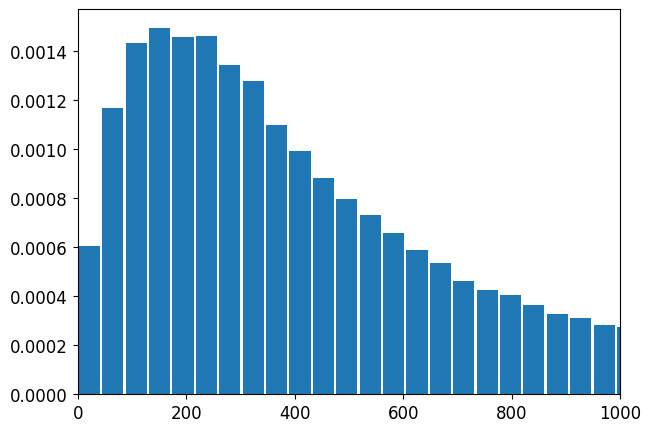

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(np.array(prior_predictive.prior_predictive.kelp_count_observed).flatten(), bins=10000, rwidth=0.9, density=True)
plt.xlim((0, 1000))

(0.0, 800.0)

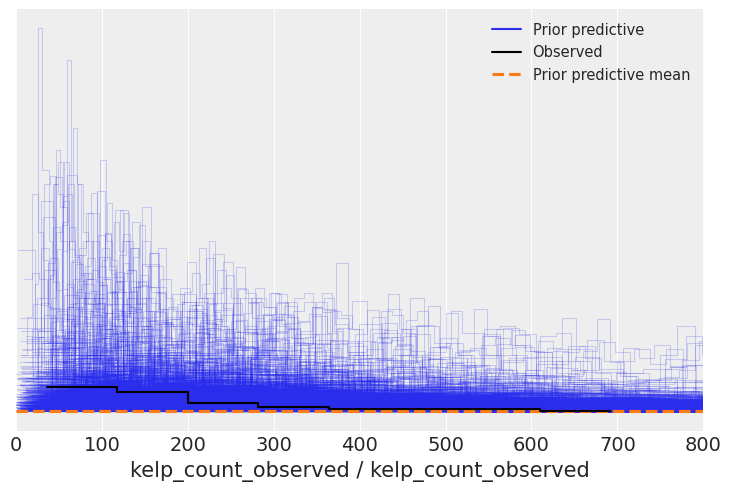

In [ ]:
az.style.use("arviz-darkgrid")
az.plot_ppc(prior_predictive, group="prior")
plt.xlim((0,800))

In [ ]:
 # sample posterior and posterior predictive
with model2:
  trace2 = pm.sample(4500, tune = 2000, target_accept = 0.9, chains = 4)

In [ ]:
with model2:
  post_p2 = pm.sample_posterior_predictive(trace2)

<Axes: xlabel='kelp_count_observed / kelp_count_observed'>

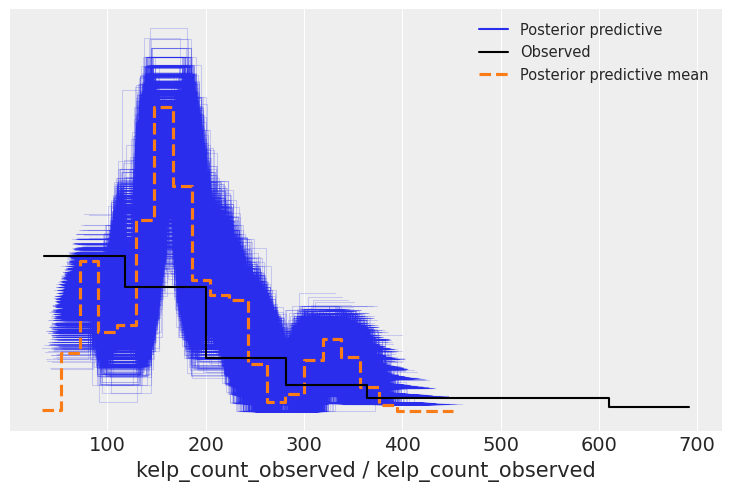

In [ ]:
az.plot_ppc(post_p2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha  5.142  0.106   4.941    5.342      0.001    0.001    5742.0   
sd_alpha  0.463  0.082   0.324    0.613      0.002    0.001    2271.0   

          ess_tail  r_hat  
mu_alpha    8058.0    1.0  
sd_alpha    4102.0    1.0

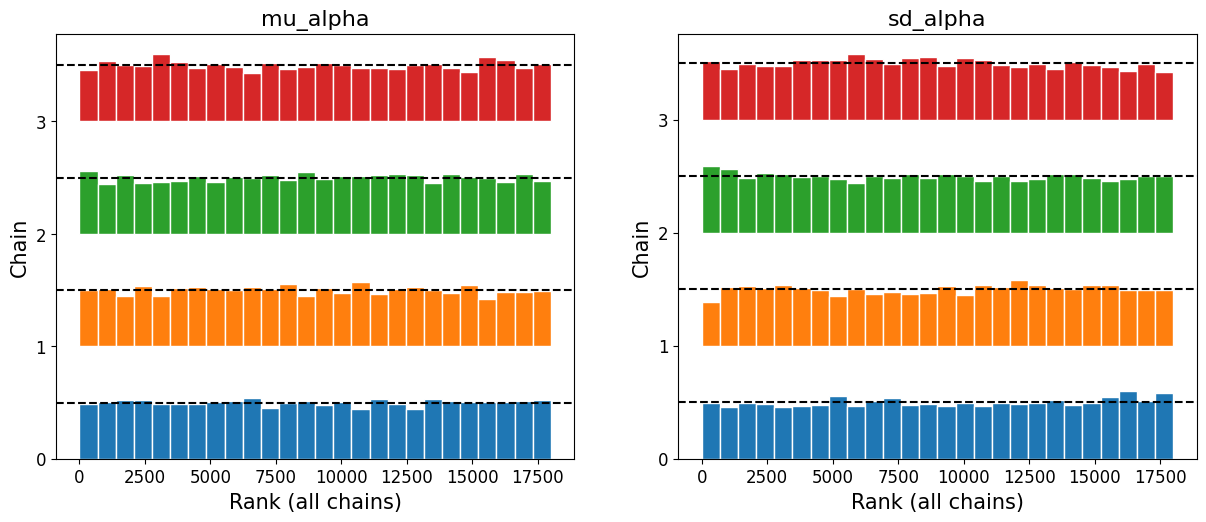

In [ ]:
az.plot_rank(trace2, var_names=['mu_alpha', 'sd_alpha'])
az.summary(trace2, var_names=['mu_alpha', 'sd_alpha'])

## Model Diagnostsics
We can see below that the r hat value is at 1. This indicates that the chains are converging to the optimum value in the posterior. 

The ess values are also above 1000s, which means our sampler did not face the issue of autocorrelation between the chains. This indicates that all the chains worked independently. 

The chains are evenly sampled in the rank plot. This is another indicator of them converging at the right value. 

### Reparametrization

The model above is sampling from two normal distributions and using them as parameters as it is for the main normal distribution which samples alpha. This is problematic because it could potentially lead to divergences. These divergences would have happened because two distributions would have the potential to get interlocked with each other. 

As Mcelearth and various classes in the course have pointed out that heirachical multilevel models should be reparam, we have implemented the same model below. 

Instead of mean being a parameter, it is added to z, a dummy variable being sampled from a normal distribution. This would ensure that we retain the modelling choices that we have in place, while we also increase the accuracy and robustness of our mode. 

/usr/local/lib/python3.9/dist-packages/pymc/model.py:1402: ImputationWarning: Data in kelp_count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


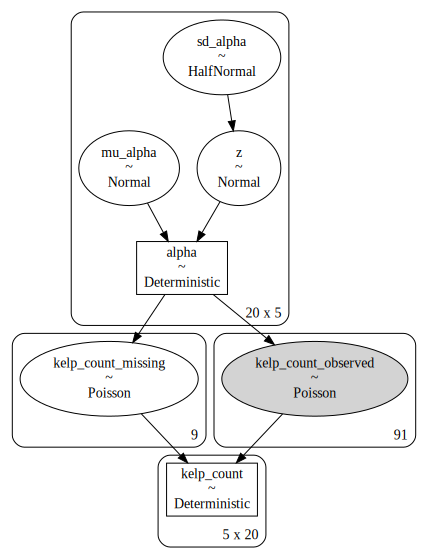

In [ ]:
with pm.Model() as model1_re:
    mu_alpha = pm.Normal('mu_alpha', mu=5.99, sigma=0.8, shape=(20,5))
    sd_alpha = pm.HalfNormal('sd_alpha', sigma=0.75, shape=(20,5))
    z = pm.Normal('z', mu=0, sigma=sd_alpha, shape =(20,5))
    alpha = pm.Deterministic('alpha',z + mu_alpha)
    lambda_ = pm.math.exp(alpha[x_vals, y_vals])
    kelp_count = pm.Poisson('kelp_count', mu=lambda_, shape=(20, 5), observed = data)
    # sample prior predictive
    prior_pred_re = pm.sample_prior_predictive(3000)
pm.model_to_graphviz(model1_re)

## Prior Predictive

The first plot shows prior predictive without the data to contrast with. We can see that the distribuition is very similar to the data and this is a good sign for our prior selection decisions.

However, in the next plot we can see why choosing this prior with this model was a better idea. It is sampling from all the data points evenly. It is to be noted that the prior predictive mean is too low. We can hope that the information from the posterior is incorporated into the data and this value gets adjusted. 

(0.0, 1000.0)

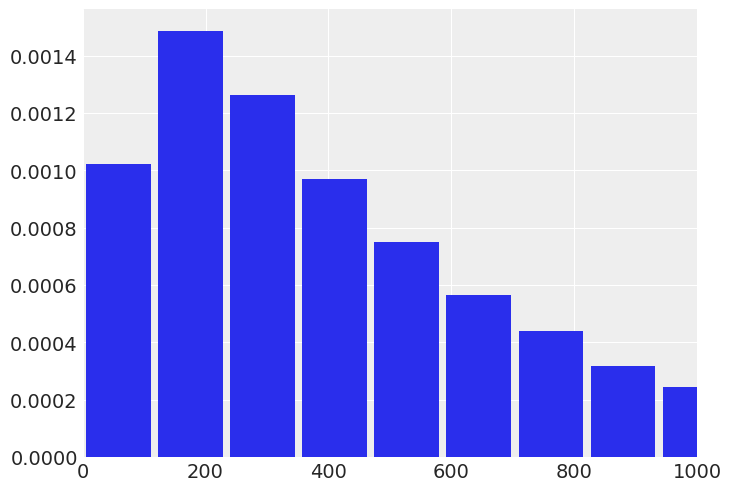

In [ ]:
plt.hist(np.array(prior_predictive.prior_predictive.kelp_count_observed).flatten(), bins=10000, rwidth=0.9, density=True)
plt.xlim((0, 1000))

(0.0, 800.0)

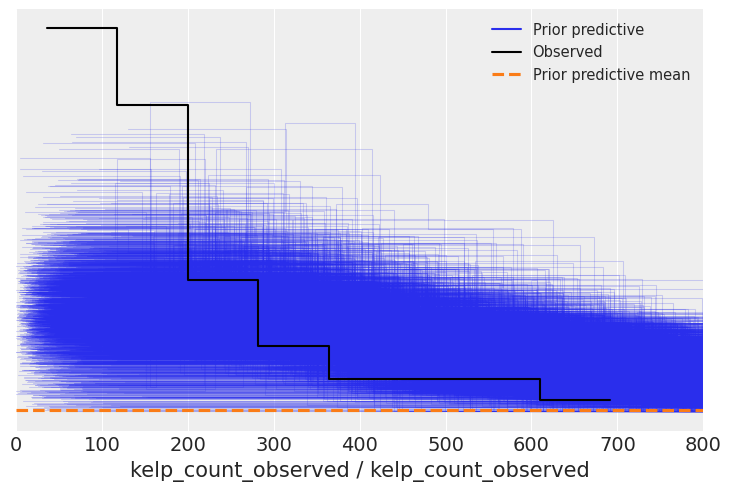

In [ ]:
az.plot_ppc(prior_pred_re, group="prior")
plt.xlim((0,800))

The code cell below was supposed to be a test for using jax to sample the posterior more quickly and effeciently. Jax would have used a Tensor Processing Unit or a Graphic Processing Unit (TPU or GPU) to increase the speed of sampling while still using Hamiltonian Monte Carlo.  

In [ ]:
# with model1_re:
#   trace_re = pm.sample_blackjax_nuts(draws=3000, tune=2000, chains=4)
#   posterior_predictive = pm.sample_posterior_predictive(trace_re)

In [ ]:
with model1_re:
  trace_re = pm.sample(draws=3000, tune=2000, target_accept = 0.9, chains=4)
  post_pred_re = pm.sample_posterior_predictive(trace_re)

ERROR:pymc:There were 2026 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: xlabel='kelp_count_observed / kelp_count_observed'>

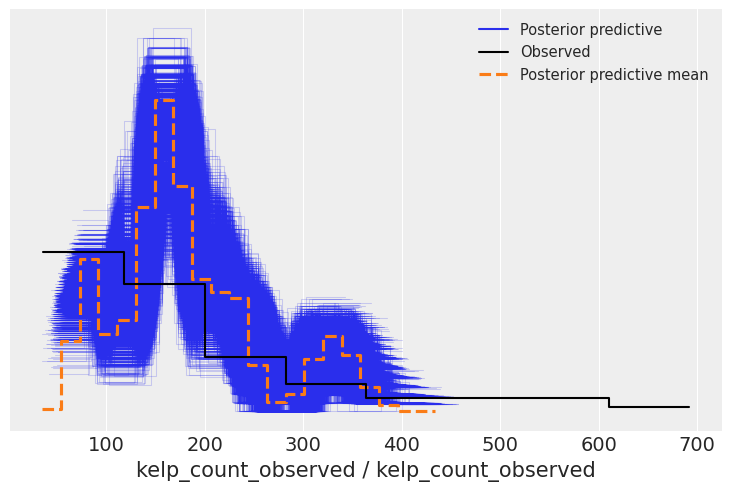

In [ ]:
az.plot_ppc(post_pred_re)

## Posterior Predictive
This graph shows us how well our model was able to predict most of the values in the dataset. This is much better than the poster


One concern is, the density across 100-200 is exaggerated compared to the actual data, but this can be attributed to the data being skewed in the first place. However, our new model's posterior does not sample for values that lie after 400. This is fairly problematic because is it is plausible that missing cells could have values that exceed 400. Not to mention, the client has already told us that they would see kelp count of 0 - 2 per cell. If our posterior is only sampling till 400, effectively the predictions are limited to observing only 1-1.2 kelp per sq. km. 

In [ ]:
x_vals = np.array([np.arange(0, 20) for i in range(0,5)]).flatten()
y_vals = np.array([np.arange(0, 5) for i in range(0,20)]).flatten()

In [ ]:
postp_mean3 = post_pred_re.posterior_predictive.kelp_count.mean(axis=0).mean(axis=0)
data_pos = data.copy()
for i in empty_cords:
  data_pos[i[0], i[1]] = postp_mean3[i[0], i[1]]

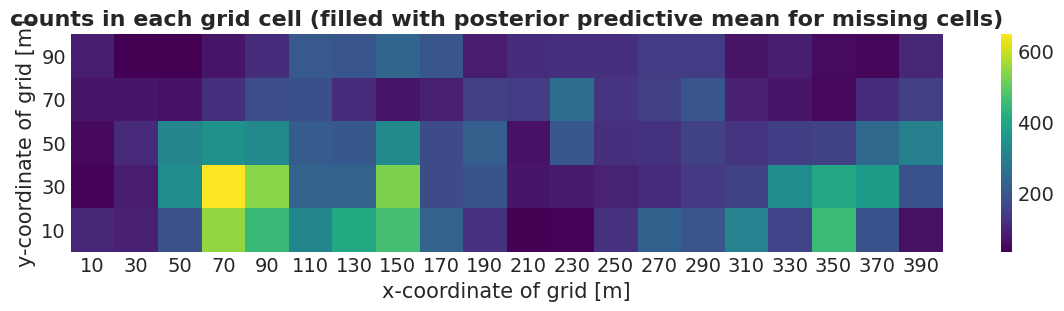

In [ ]:
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (filled with posterior predictive mean for missing cells)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_pos, origin='lower')
plt.xticks(np.arange(data_pos.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_pos.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.grid(False)
plt.show()

/usr/local/lib/python3.9/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


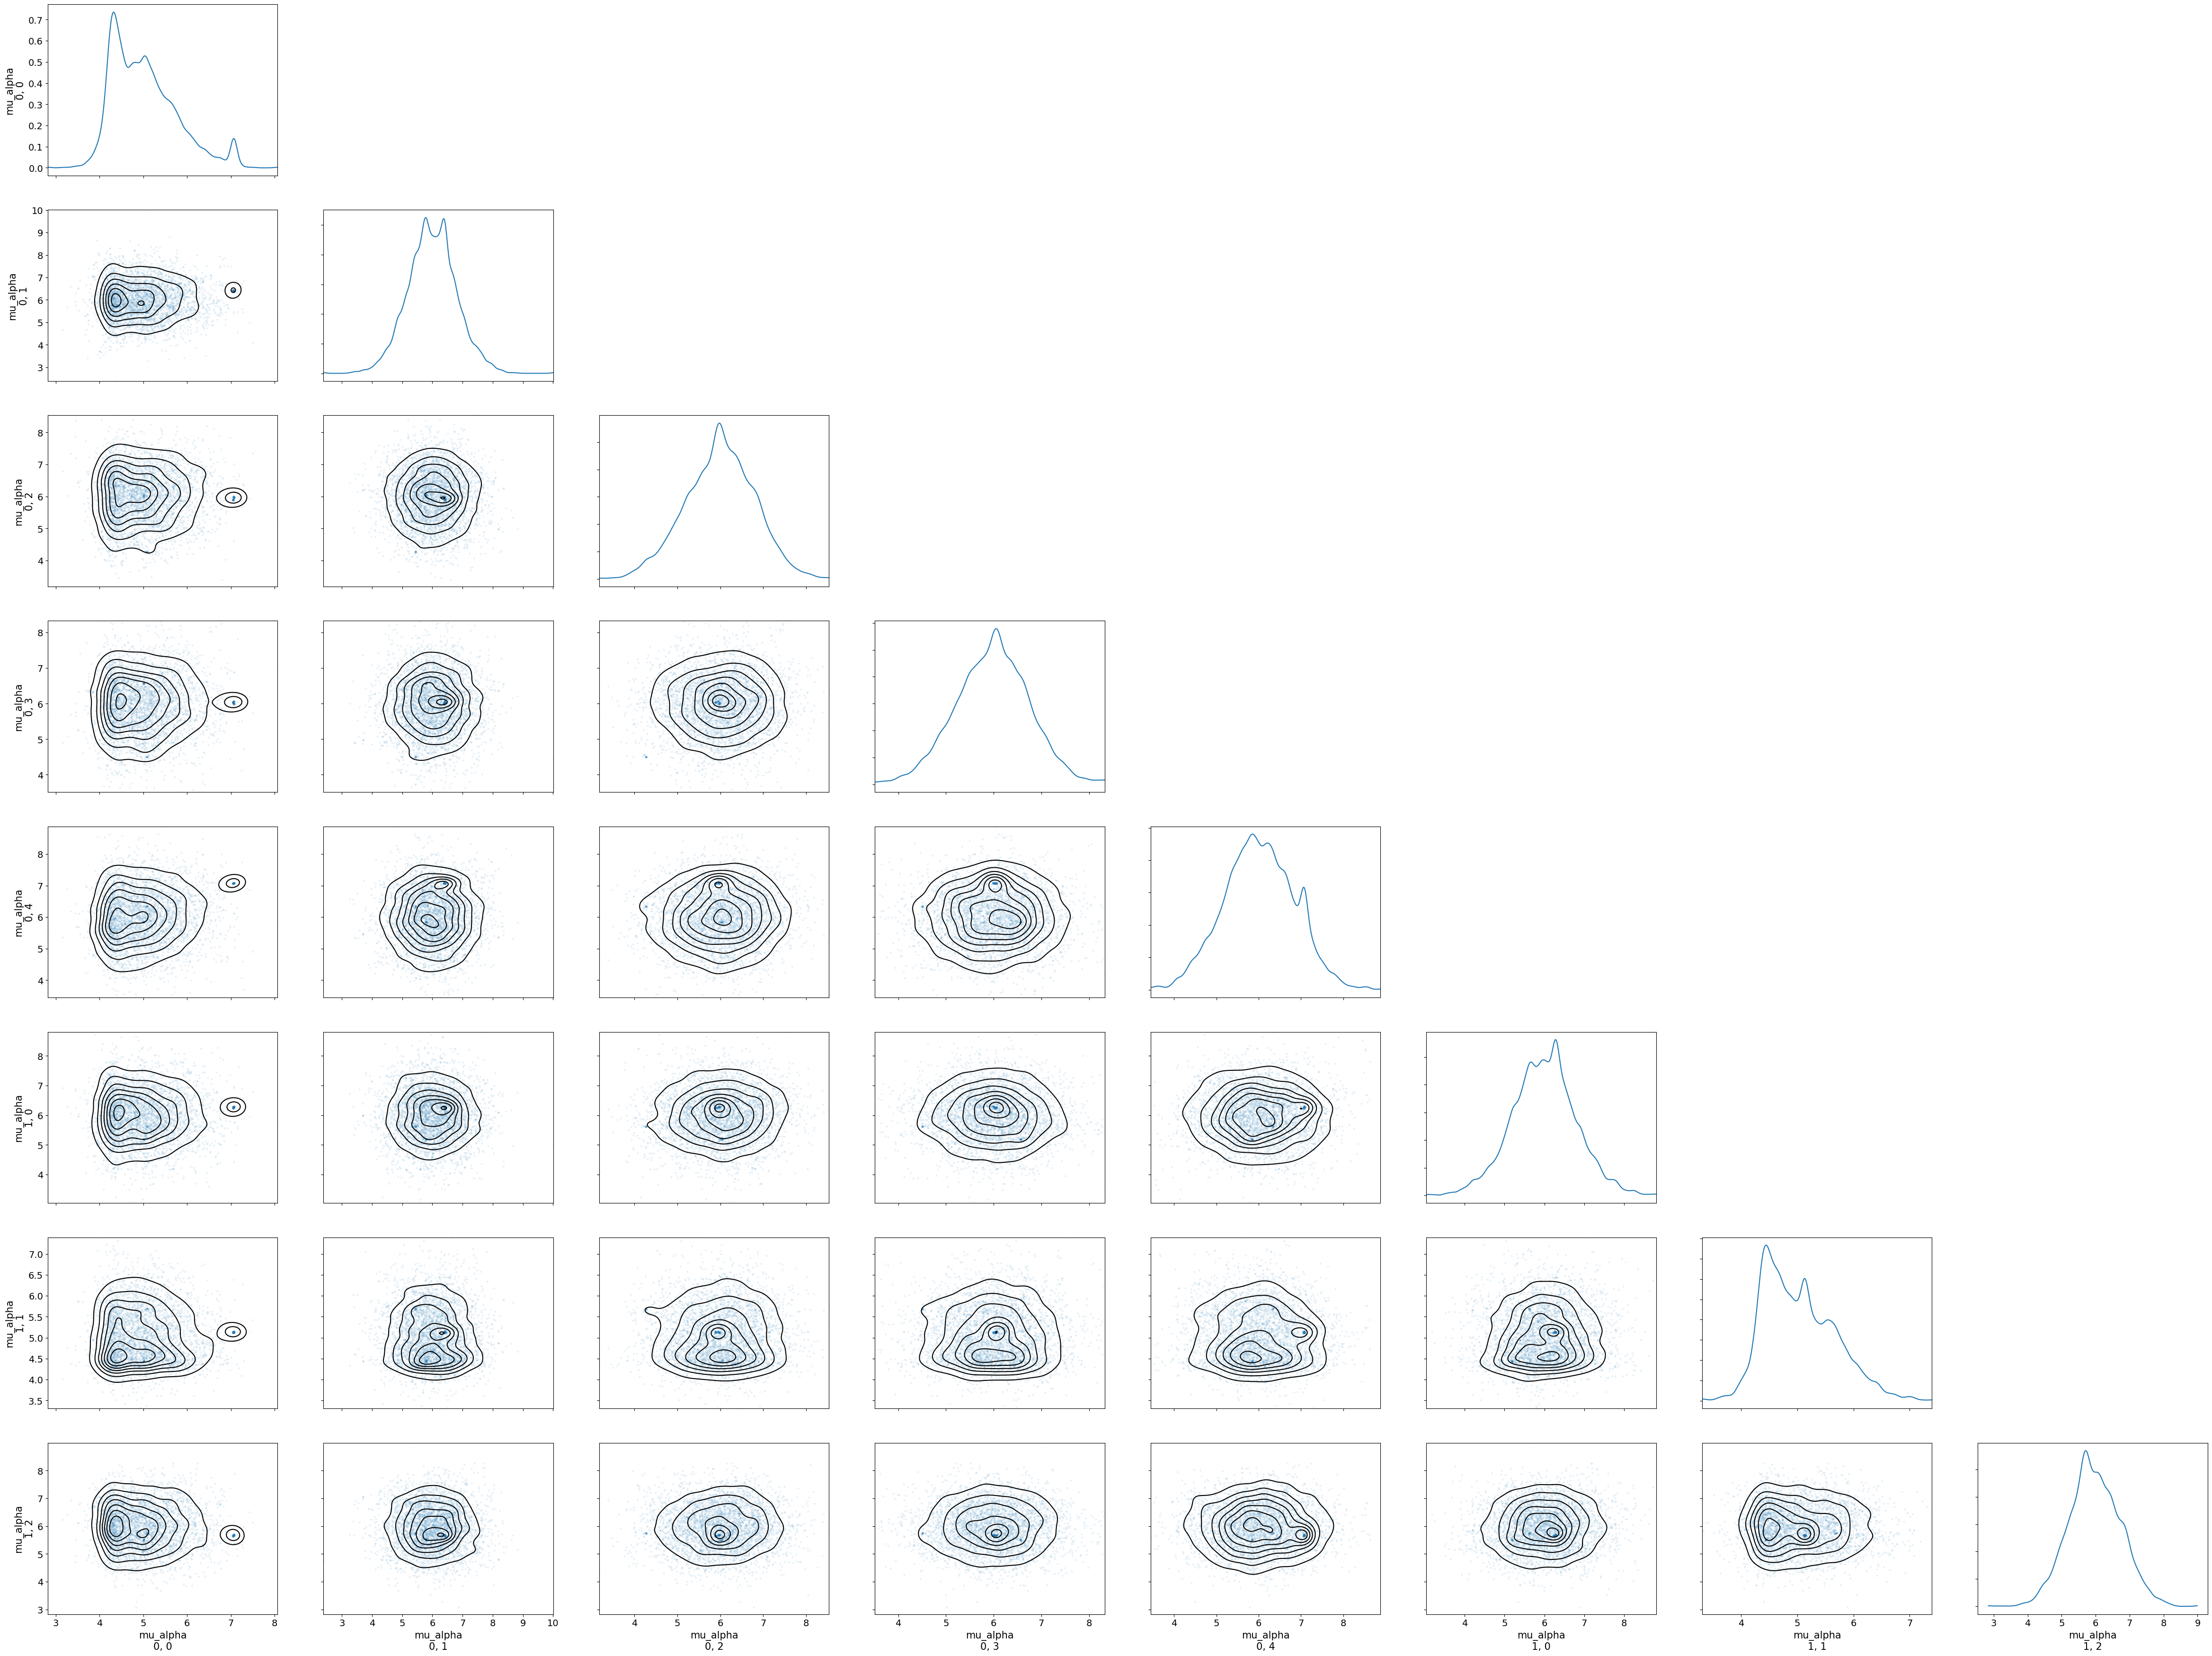

In [ ]:
ax = az.plot_pair(
    trace_re,
    marginals=True,
    var_names=['mu_alpha', 'sd_alpha'],
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

So far, we have concluded that this model was the best possible way to fit this dataset because every cell was sampled from different distributions. We are assuming that this level of "personalization" would help us fit the data well. 

Even the rhat values and rank plots have proved that our sampler was working correctly. The partial pooling model (without reparametrization) too, seemed alright. However, the pair plot above can show us what is going on. This pair plot shows us how the paramters for the main normal distribution were being sampled sepearately. We can see there is mu_alpha (0,0) and the same for (1,1), (0,1) etc. These correlation plots show how the samples were getting locked into different peaks. 

Even the sampler warned us that 10% of the samples were taken from a divergence. This only happens when the monte carlo chains can not converge at the same posterior distribution. This is problematic for us because we are relying on the assumption that these points are a proxy for an actual posterior distribution. 

Now, if there was a problem with our sampler or our priors, our previous models would have had divergence too. It is also important to point out that these divergences only showed up when we performed reparamterized partial pooling, essentially when we let our sampler analyse every point independently. Therefore, an argument could be made that the data itself is correlated according to the positioning of the cell. 

We explore this line of thinking in the optional challenge below. 



## Optional stretch goals


## Geographical Correlation

In the next few cells, we have demonstrated how the neighbouring cells are correlated with each other. First, we created a scatter plot where x axis shows the value of the cell, and y shows the value of a neighbouring cell. It can be clearly observed that there is a trend in the graph. 

Furthermore, the Pearson's correlation is also at 0.65, which suggests a moderate to strong correlation between, what until now, we assumed were uncorrelated rvs. 

In [ ]:
correlations = [[],[]]
for i in range(data.shape[0]):
  for j in range(data.shape[1]-1):
    if np.isnan(data[i,j]) or np.isnan(data[i, j+1]):
      continue
    correlations[0].append(data[i,j])
    correlations[1].append(data[i, j+1])
np.corrcoef(correlations[0], correlations[1])

array([[1.        , 0.65320947],
       [0.65320947, 1.        ]])

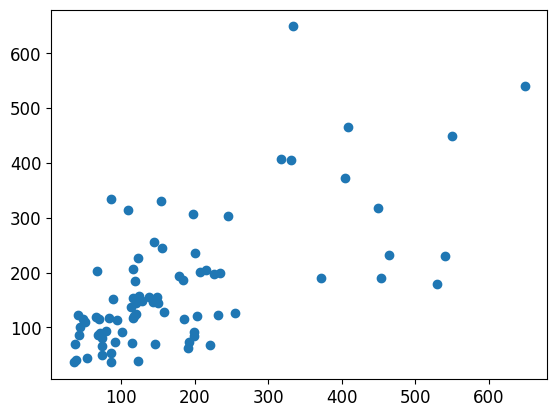

In [ ]:
plt.scatter(correlations[0], correlations[1])

## Spatial Poisson Model

Spatial models are a family of models that assume that there are other factors such as time of day, geographical location etc. that are affecting the distribution of random variables. This means, our varaibles are correlated due to reasons that are completely unknown to us. Spatial dependence is attempting to model correlated random effects, which accounts for the fact that events occurring in nearby locations are more likely to be similar to each other than to events occurring in distant locations. 

In the context that was present to us, we can speciall see that in action. Kelp counts are affected microbiomes that exist in the ocean (Puebla et al, 2022). This means there could be natural phenomenon that are present in one location that increase or decrease the number of kelp that are present there. Now, it also entirely plausible that this phenomenon would not affect the number of kelp in a far away region. 

For eg. if there is a oil spill that had happened on one coast, this would reduce the number of kelp that are near land, but, after some distance, this particular event would not affect the number of kelp in a completely different region. This is the motivation behind using a spatial model.

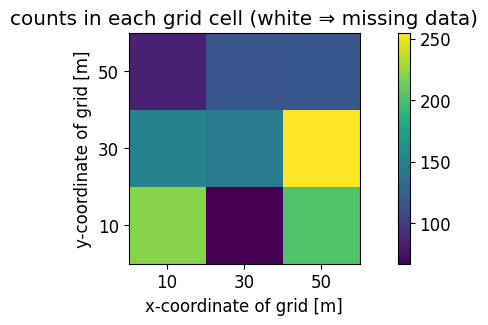

In [ ]:
data_o = data[2:5, 9:12]
grid_count_x = 3  # number of grid cells in the x and y directions
grid_count_y = 3
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

plt.figure(figsize=(10, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_o, origin='lower')
plt.xticks(np.arange(data_o.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_o.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
x_vals = np.array([np.arange(0, 3) for i in range(0,3)]).flatten()
y_vals = np.array([np.arange(0, 3) for i in range(0,3)]).flatten()
print(y_vals)

[0 1 2 0 1 2 0 1 2]


In [ ]:
x_vals, y_vals = np.meshgrid(np.arange(3), np.arange(3), indexing="ij")
x_vals = x_vals.flatten()
y_vals = y_vals.flatten()

In [ ]:
data_a = data_o.tolist()
print(data_a)
data_on = []
for i in range(data_o.shape[0]):
   for j in range(data_o.shape[1]):
     if j+1 != data_o.shape[1]:
       data_on.append([data_a[i][j], data_a[i][j+1]])
     else:
       data_on.append([data_a[i][j], data_a[i][j-1]])

[[221.0, 67.0, 203.0], [151.0, 145.0, 255.0], [84.0, 117.0, 118.0]]


In [117]:

data_on = np.array(data_on).reshape(9,2)

## Mathematical Modelling 

We have created clusters with one point and its neighbour. Let A be point 1 and B be point 2. The model would need to use a multivariate normal distribution since we are not just using one variable at one point. We are trying to model two rvs together and one of the main ways to do it is to use a multivariate normal distribution. 

This would require two parameters, mean and the correlation matrix. This matrix models how well the two rvs need to be related to each other. The mean is modeled from two seperate normal distributions for each point A and point B. The means for these distributions are 5.9 and 5.7. We have decided to not use same means in order to ensure that there is some variation that gets captured. The standard deviation for both the normal distributions are 0.75 and 0.5 respectively. These sigma values are kept less than 1 because we do not want our distributions to get too concentrated along the mean. 

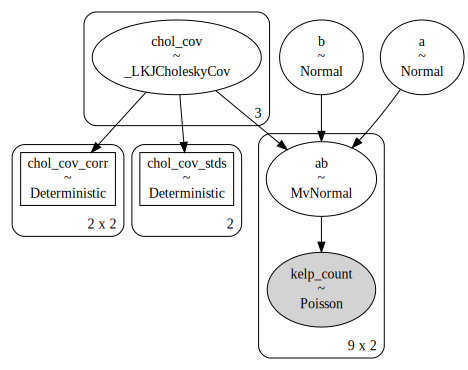

In [ ]:
from pytensor import tensor as at
with pm.Model() as m14_1:
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov("chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    a = pm.Normal("a", 5.7, 0.75)  # Prior for cell one
    b = pm.Normal("b", 5.9, 0.5)  # Prior for neighbouring cell
    ab = pm.MvNormal("ab", mu = at.stack([a, b]), chol=chol, shape=(9,2))
    lambda_ = pm.math.exp(ab)
    kelp_count = pm.Poisson('kelp_count', mu=lambda_,observed=data_on, shape=(9,2))
    prior_pred = pm.sample_prior_predictive(1000)
    #trace_14_1 = pm.sample(4000, tune=4000, target_accept=0.9)
pm.model_to_graphviz(m14_1)

(0.0, 800.0)

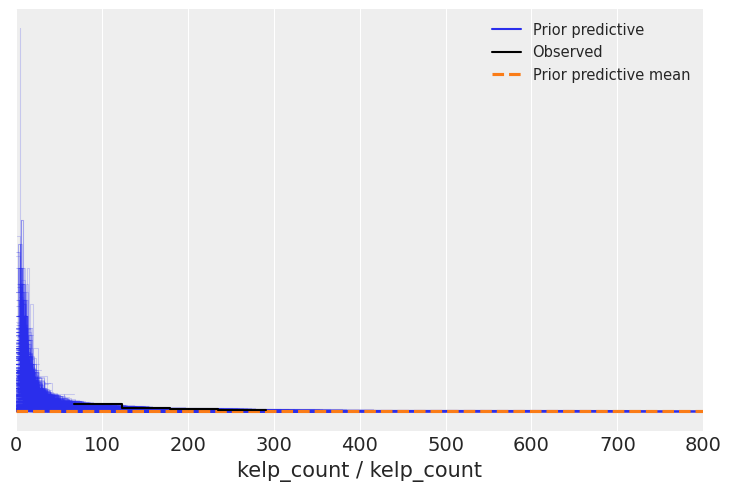

In [ ]:
az.plot_ppc(prior_pred, group='prior')
plt.xlim((0,800))

Since the sample size in this dataset, we expect to observe a prior predictive that does not make sense. 

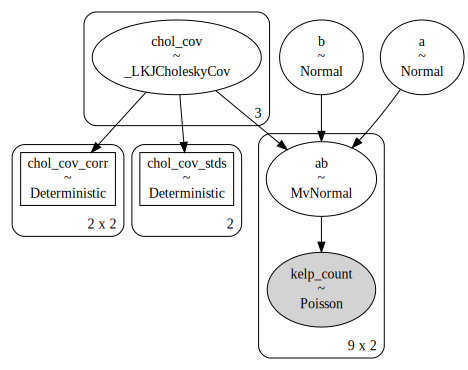

In [ ]:
from pytensor import tensor as at
with pm.Model() as m14_1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    # sample prior predictive
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov("chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    a = pm.Normal("a", 2.3, 0.75)  # Prior for cell one
    b = pm.Normal("b", 2.2, 0.5)  # Prior for neighbouring cell
    ab = pm.MvNormal("ab", mu = at.stack([a, b]), chol=chol, shape=(9,2))
    lambda_ = pm.math.exp(ab)
    kelp_count = pm.Poisson('kelp_count', mu=lambda_,observed=data_on, shape=(9,2))
pm.model_to_graphviz(m14_1)
    #trace_14_1 = pm.sample(4000, tune=4000, target_accept=0.9)

In [ ]:
with m14_1:
  trace_14_1 = pmjax.sample_numpyro_nuts(2000, tune=1500, target_accept=0.9)

Compiling...
Compilation time =  0:00:54.763233
Sampling...


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling time =  0:00:07.467055
Transforming variables...
Transformation time =  0:00:00.635117


In [ ]:
with m14_1:
  post_predr1 = pm.sample_posterior_predictive(trace_14_1)

<Axes: xlabel='kelp_count / kelp_count'>

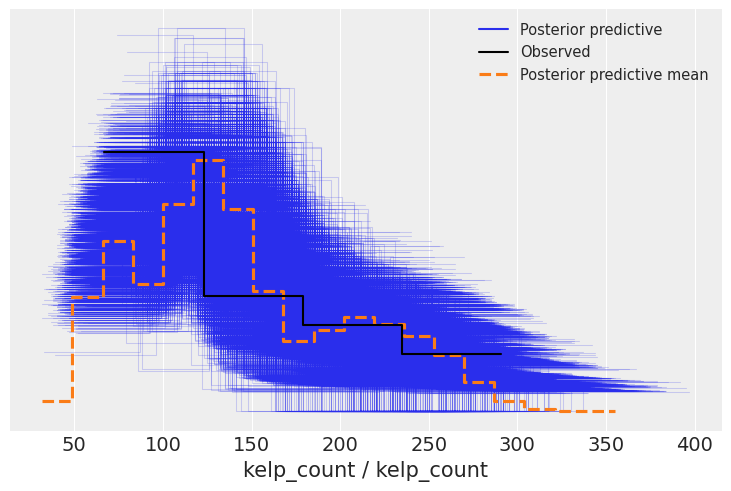

In [ ]:
az.plot_ppc(post_predr1)

(array([2., 0., 2., 0., 2., 0., 0., 1., 1., 1.]),
 array([ 69.11137474,  87.33641349, 105.56145224, 123.78649098,
        142.01152973, 160.23656848, 178.46160723, 196.68664598,
        214.91168473, 233.13672348, 251.36176223]),
 <BarContainer object of 10 artists>)

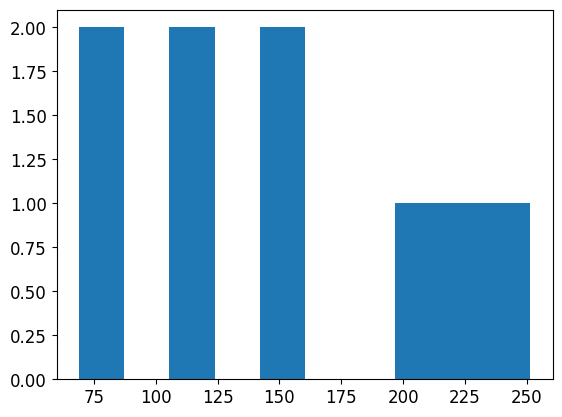

In [ ]:
sams = trace_14_1.posterior.ab[:,:,:,0].mean(axis=0).mean(axis=0)
sams = np.exp(sams)

## Main Model
The previous model was fit to 9 cells only. 

In [ ]:
data_onn = []
for i in range(data.shape[0]):
   for j in range(data.shape[1]):
     lst = []
     if j != data.shape[1]:
       data_onn.append([data[i][j], data[i][j-1]])
     else:
       data_onn.append([data[i][j], data[i][j+1]])

/usr/local/lib/python3.9/dist-packages/pymc/model.py:1402: ImputationWarning: Data in kelp_count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


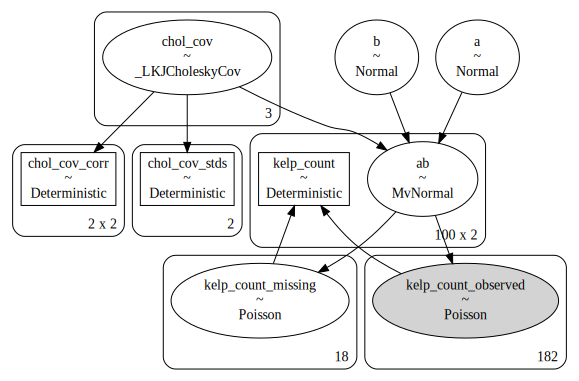

In [ ]:
from pytensor import tensor as at
with pm.Model() as m14_2:
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov("chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    a = pm.Normal("a", 5.5, 0.75)  # Prior for cell one
    b = pm.Normal("b", 5.5, 0.5)  # Prior for neighbouring cell
    ab = pm.MvNormal("ab", mu = at.stack([a, b]), chol=chol, shape=(100,2))
    lambda_ = pm.math.exp(ab)
    kelp_count = pm.Poisson('kelp_count', mu=lambda_,observed=data_onn, shape=(100,2))
pm.model_to_graphviz(m14_2)

In [ ]:
#After running this code cell, you would encounter "No free random variables."
#This is because the missing values that are being imputed by pymc are in the determinstic form.

with pm.Model() as m14_2:
  trace_14_2 = pm.sample(3000, tune=2000, target_accept=0.9)
  trace_14_1.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}, inplace=True)

SamplingError: ignored

The code cell above is not working because pymc uses a deterministic form to impute nan values. Up until now this process was working well, however, in the model above, there are no other free variables that it can sample from a distribution. This is why we are removing the nan values in the data and putting zeros in place. 

The consequences of this decision would be evident in the next section. 

In [ ]:
#Creating clusters where nan values have been converted to 0s. This ensures that the previous error do nat get raised. 
data_wnan = []
for i in range(data1.shape[0]):
   for j in range(data1.shape[1]):
     lst = []
     #See if this is not the end of the array.
     if j != data1.shape[1]:
       #Add the neighbour and the cell in a sub-array.
       data_wnan.append([data1[i][j], data1[i][j-1]])
     else:
       #Since right neighbour is not available, the left one would be added. 
       data_wnan.append([data1[i][j], data1[i][j+1]])
data_wnan = np.array(data_wnan)

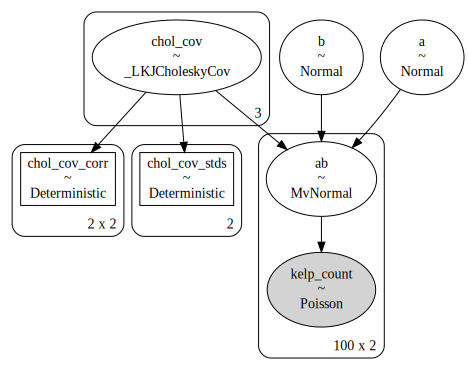

In [ ]:
from pytensor import tensor as at
with pm.Model() as m14_3:
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov("chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    a = pm.Normal("a", 5.5, 0.5)  # Prior for cell one
    b = pm.Normal("b", 5.5, 0.75)  # Prior for neighbouring cell
    ab = pm.MvNormal("ab", mu = at.stack([a, b]), chol=chol, shape=(100,2))
    lambda_ = pm.math.exp(ab)
    kelp_count = pm.Poisson('kelp_count', mu=lambda_,observed=data_wnan, shape=(100,2))
pm.model_to_graphviz(m14_3)

In [ ]:
#Run this cell to see how neighbour clustering has been correctly performed. (Output cleared in pdf to avoid clutter)

#print(data_wnan)

This cell below also shows how we managed to fit a model in seconds by using a sampler that relies on jax and does not use a CPU. 

The instructions has mentioned how it was supposed to take hours, but it only took seconds with this method. This was not covered in the course material, nor taught. 

Source: https://github.com/pymc-devs/pymc/wiki/Set-up-JAX-sampling-with-GPUs-in-PyMC-v4 and https://www.pymc-labs.io/blog-posts/pymc-stan-benchmark/


In [120]:
with m14_3:
  trace_14_3 = pmjax.sample_numpyro_nuts(3000, tune=2000, target_accept=0.9)

Compiling...
Compilation time =  0:00:03.509810
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:07.899568
Transforming variables...
Transformation time =  0:00:00.124205


In [121]:
with m14_3:
  post_predr2 = pm.sample_posterior_predictive(trace_14_3, extend_inferencedata=True)

In [118]:
## Uncomment and run this cell to see the correctly sampled data structures in the posterior. 
#print(trace_14_3.posterior)

<Axes: xlabel='kelp_count / kelp_count'>

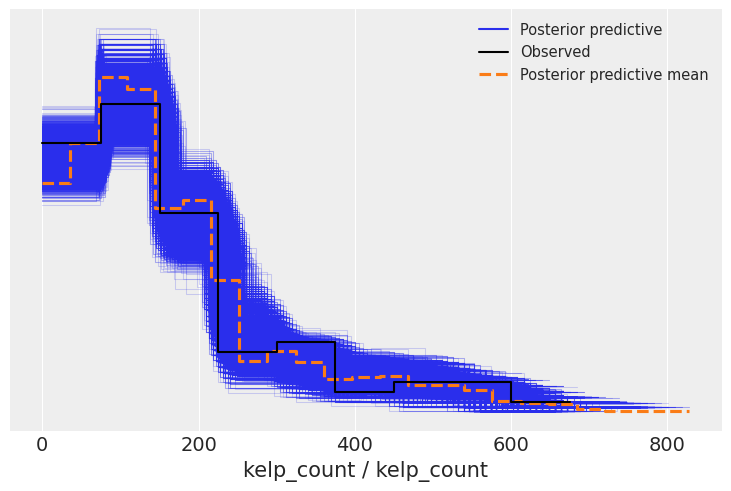

In [122]:
az.plot_ppc(post_predr2)

In [ ]:
post_predr2 = post_predr2.posterior_predictive.kelp_count[:,:,:,0].mean(axis=0).mean(axis=0).values

In [ ]:
new = post_predr2.reshape(5,20)

In [116]:
#print(new)

In [ ]:
#print(empty_cords)
empty_xs = [a[0] for a in empty_cords]
empty_ys = [a[1] for a in empty_cords]

[2, 16, 6, 3, 4, 7, 8, 0, 13]
[0, 0, 1, 2, 2, 2, 2, 3, 3]


In [ ]:
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(new, origin='lower')
plt.xticks(np.arange(new.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(new.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.grid(False)
plt.show()

The previous cell has used the values from posterior predictive distribution to fill the gaps that were present. As we can see in the graph, these values are very low. This is happening because numpy has replaced nan values with 0 in `data1`. 

As evident in the posterior predictive, this replacement has not only influenced the main missing cell's estimation, but it might have reduced the posterior value of cells which are on its left. A plausible reason for this issue could be, when we were performing feature engineering, we used the value of right cells to create a cluster. The above mentioned issue gets worse when we consider how there are some missing cells where even their neighbour are missing.

### Neighbour Estimation

As seen in other spatial Poisson models (Mehebbi et al, 2011), we would need to consider the mean kelp_count of neighbours of a particular cell in order to estimate what would its count plausibly be. 

This fault of our prediction could only be observed when we saw the posterior predictive cell chart above. It seemed like the model had been able to capture all if not most of the variation in the data, but, missing cell imputation would need extra steps. 

The process of taking the mean of all the posterior values and then finding the missing value has been performed below.

### More Feature Engineering

In the next code cell, we have taken the average of neighbouring cells to estimate their value. There are some cells that have their neighbours missing or are in the corner. In that scenario, we have used the other 3 cells to estimate their true value. 

In [90]:
neigh_3_corner = []
averages = {}

for i in range(len(data)):
   for j in range(len(data[i])):
     #Checking for null values in the first row or column
     if (np.isnan(data[i][j])) and ((i == 0) or (j == 0)):
       neigh_3_corner.append((i,j))

for i in range(len(neigh_3_corner)):
  avg = 0
  if neigh_3_corner[i][0] == 0:
    avg = int((data[neigh_3_corner[i][0], neigh_3_corner[i][1] + 1] + data[neigh_3_corner[i][0], neigh_3_corner[i][0] - 1] + data[neigh_3_corner[i][0] + 1, neigh_3_corner[i][0]])/3)
    averages[neigh_3_corner[i]] = avg
  else:
    avg = int((data[neigh_3_corner[i][0] + 1, neigh_3_corner[i][1]] + data[neigh_3_corner[i][0] - 1, neigh_3_corner[i][1]] + data[neigh_3_corner[i][0], neigh_3_corner[i][1] + 1])/3)
    averages[neigh_3_corner[i]] = avg

{(0, 2): 218, (0, 16): 186, (3, 0): 212.0}


In [103]:
neigh_3_nan = [(2, 7),(2, 3), (2,8), (2, 4)]

for i in neigh_3_nan[:2]:
  averages[i] = int((data[i[0], i[1] -1] + data[i[0] - 1, i[1]] + data[i[0] + 1, i[1]])/3)

for i in neigh_3_nan[2:]:
  averages[i] = int((data[i[0] + 1, i[1]] + data[i[0] - 1, i[1]] + data[i[0], i[1] + 1])/3)

In [112]:
#4 neighbours = 1,6 and 3,13
neigh_4 = [(1,6), (3,13)]
for i in neigh_4:
  averages[i] = int((data[i[0] + 1, i[1]] + data[i[0] - 1, i[1]] + data[i[0], i[1] + 1] + data[i[0], i[1] - 1])/3)
#averages

In [113]:
dummy = data.copy()
for a,b in averages.items():
  dummy[a[0], a[1]] = b

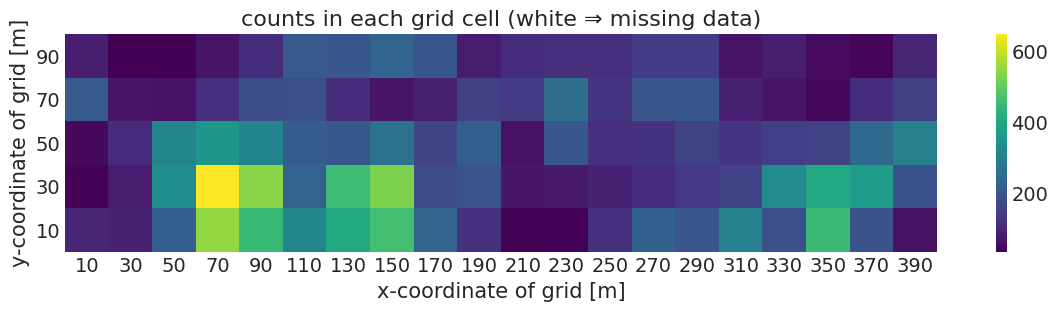

In [114]:
plt.rcParams.update({'font.size': 12})
az.style.use("arviz-darkgrid")
grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width


plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(dummy, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.grid(False)
plt.show()

## Model Debugging



mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  4.633  0.142   4.367    4.896      0.001    0.001   23037.0    8350.0   
b  4.596  0.146   4.316    4.862      0.001    0.001   21027.0    9366.0   

   r_hat  
a    1.0  
b    1.0

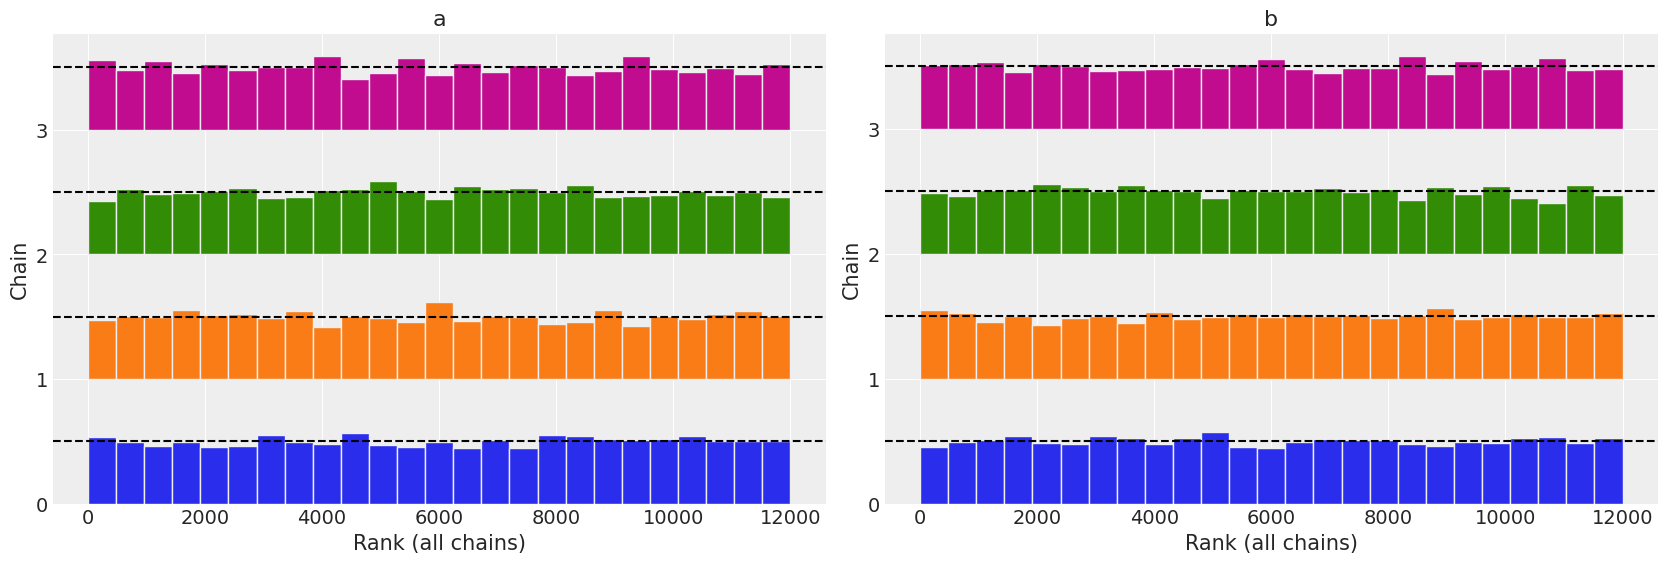

In [115]:
az.plot_rank(trace_14_3, var_names=['a', 'b'])
az.summary(trace_14_3, var_names=['a', 'b'])

This model has performed as expected. We can see that the HMC chains have traversed across the posterior space and converged towards similar values. This is evident on the fact that there are not too many significant peaks or troughs in the rank plot chart. The ess samples are also very high, which means that we did not loose too many draws to autocorrelated chains (essentially, when a single chain goes off track compared to other ones). This also validates all the mathematical modelling that we have performed above and shows how our model construction can map this phenomenon well. 

### Recommendations to The Client

We can clearly see how the spatial Poisson model was much better than all the other models that we have seen until now. This means that it was best able to replicate the data-generating process. This is because kelp counts are influenced by geographical and regional factors, and one way to map this is by using a model that considers that the samples could possibly be correlated. 

The only way to see what missing values could have looked like, is by seeing how other cells around it have been modelled. The last model does this considerably well.

## LOs Used

#### Sampling Approximation and Modelling
I use these LO to create a novel way to impute missing kelp count distribution by using a model that has a multinormal distribution and two normal distributions. I explain why this model is the right choice given the phenomenon that is being modeled. Every component of this new method was discussed and defended after analysing how correlated our dataset was.

I also used these LOs to use a non-centered partial pooling model. 

#### Python Implementation
The optional prompt had clearly stated that this model would take hours to fit. I did that in 7 seconds. That's a 98% improvement in speed and compuational efficiency. I went above and beyond, and managed to satsfy the constraints that were set in place in the question. 

#### Model Debugging 
Throughout the assignment, I use prior and posterior predictive checks to show how we need to constantly improve the model. It was an iterative process and after every model, I explain the consequences of posterior and prior predictive means while comparing it to the dataset. At the end, the posterior check shows how well the model had fit the data.

## Sources 

https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-022-01235-w 

https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-11-133 

https://www.youtube.com/@rmcelreath Mcelearth's youtube channel was extremely helpful for intuition. 

https://github.com/pymc-devs/pymc-resources/tree/main/Rethinking_2 This github repo was cited in the course too. 

https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-11-133 